# Car sales price forecast

Importing libraries

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor

Reading the dataset

In [43]:
df = pd.read_csv('data.csv')
df.head()

,Unnamed: 0,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
0,0,alfa-romeo,Alfa Romeo GTV,red,Oct-95,1995,1300,148,201,Manual,Petrol,"10,9 l/100 km",260 g/km,160500.0,2.0 V6 TB
1,1,alfa-romeo,Alfa Romeo 164,black,Feb-95,1995,24900,191,260,Manual,Petrol,NaN,#NAME?,190000.0,"Q4 Allrad, 3.2L GTA"
2,2,alfa-romeo,Alfa Romeo Spider,black,Feb-95,1995,5900,110,150,Unknown,Petrol,NaN,#NAME?,129000.0,ALFA ROME 916
3,3,alfa-romeo,Alfa Romeo Spider,black,Jul-95,1995,4900,110,150,Manual,Petrol,"9,5 l/100 km",225 g/km,189500.0,2.0 16V Twin Spark L
4,4,alfa-romeo,Alfa Romeo 164,red,Nov-96,1996,17950,132,179,Manual,Petrol,"7,2 l/100 km",#NAME?,96127.0,"3.0i Super V6, absoluter Topzustand !"


It contains data on cars manufactured between 1995 and 2023, listed for sale on one of Germany's largest car sales websites, autoscout24. Link to dataset source:
https://www.kaggle.com/datasets/wspirat/germany-used-cars-dataset-2023.

The name and format of the variables in the first 5 rows of the dataset are displayed.

In [44]:
df.shape

(251079, 15)

The dataset has 15 variables and 251079 entries.

## Data Cleaning

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251079 entries, 0 to 251078
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                251079 non-null  int64  
 1   brand                     251079 non-null  object 
 2   model                     251079 non-null  object 
 3   color                     250913 non-null  object 
 4   registration_date         251075 non-null  object 
 5   year                      251079 non-null  object 
 6   price_in_euro             251079 non-null  object 
 7   power_kw                  250945 non-null  object 
 8   power_ps                  250950 non-null  object 
 9   transmission_type         251079 non-null  object 
 10  fuel_type                 251079 non-null  object 
 11  fuel_consumption_l_100km  224206 non-null  object 
 12  fuel_consumption_g_km     251079 non-null  object 
 13  mileage_in_km             250927 non-null  f

The variable type and the number of non-null entries for each variable are displayed. Variables such as _price_in_euro_ are incorrectly formatted as object instead of float64. The difference between the variables in the number of non-null counts indicates missing values in the dataset.

In [46]:
df.drop('Unnamed: 0', inplace=True, axis=1)
df.drop('registration_date', inplace=True, axis=1)
df.drop('power_kw', inplace=True, axis=1)
df.drop('offer_description', inplace=True, axis=1)

The _Unnamed: 0_ column is removed because there is already an index in the dataset. The _registration_date_ and _power_kw_ columns are removed because they are not needed, the _year_ column is more relevant than _registration_date_, and _power_ps_ measures machine power in a different unit than _power_kw_. The _offer_description_ column is removed because of its lack of usability.

In [47]:
pd.unique(df['brand'])

array(['alfa-romeo', 'aston-martin', 'audi', 'bentley', 'bmw', 'cadillac',
       'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo', 'daihatsu',
       'dodge', 'ferrari', 'fiat', 'ford', 'honda', 'hyundai', 'infiniti',
       'isuzu', 'jaguar', 'jeep', 'kia', 'lada', 'lamborghini', 'lancia',
       'land-rover', 'maserati', 'mazda', 'mercedes-benz', 'mini',
       'mitsubishi', 'nissan', 'opel', 'peugeot', 'porsche', 'proton',
       'renault', 'rover', 'saab', 'seat', 'skoda', 'smart', 'ssangyong',
       'toyota', 'volkswagen', 'volvo'], dtype=object)

All car brands present in the dataset are displayed.

In [48]:
df['brand'].replace('-', '', inplace=True, regex=True)
df['model'].replace(' ', '', inplace=True, regex=True)
df['model'].replace('-', '', inplace=True, regex=True)
df['brand'] = df['brand'].apply(str.upper)
df['model'] = df['model'].apply(str.upper)

The car brands and models are formatted in such a way that they are written in capital letters, without blanks or dashes.

In [49]:
for index, row in df.iterrows():
    brand = row['brand']
    model = row['model']
    new_model = model.replace(brand, '')
    df.at[index, 'model'] = new_model
df['model'].replace('', np.nan, inplace=True, regex=True)
df.dropna(inplace=True)
df.tail()

,brand,model,color,year,price_in_euro,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km
251071,VOLVO,XC60,silver,2023,81350,310,Automatic,Hybrid,"7,4 l/100 km",167 g/km,60.0
251072,VOLVO,XC60,silver,2023,55400,197,Automatic,Diesel,"5,6 l/100 km",142 g/km,5000.0
251073,VOLVO,XC60,silver,2023,54500,197,Automatic,Diesel,"5,6 l/100 km",142 g/km,5900.0
251075,VOLVO,XC90,white,2023,89690,235,Automatic,Diesel,"7,6 l/100 km",202 g/km,4900.0
251076,VOLVO,V60,white,2023,61521,197,Automatic,Diesel,"4,7 l/100 km",125 g/km,1531.0


Since the column model contains the brand name, it is removed because it is not necessary. Entries without a specific model are removed.

In [50]:
df['year'] = pd.to_datetime(df['year'], errors='coerce')
df['year'] = df['year'].dt.year
df.dropna(inplace=True)

The _year_ column is formatted to contain only the year in which the car was produced. Data not containing the year are deleted.

In [51]:
df['transmission_type'].replace('Unknown', np.nan, inplace=True, regex=True)
df.dropna(inplace=True)

Records with _transmission_type_type_ as _Unknown_, as well as those without this type, are removed.

In [52]:
df['fuel_type'].replace('Unknown', np.nan, inplace=True, regex=True)
aux = df.loc[df['fuel_type'] == 'Electric', 'fuel_consumption_g_km'].tolist()
df.loc[df['fuel_type'] == 'Electric', 'electric_range'] = aux
df.drop('fuel_consumption_g_km', inplace=True, axis=1)
df.loc[df['fuel_type'] == 'Electric', 'fuel_consumption_l_100km'] = 0
df.loc[df['fuel_type'] != 'Electric', 'electric_range'] = 0
df['fuel_type'].replace('Other', np.nan, inplace=True, regex=True)
df['fuel_type'].replace('Hydrogen', np.nan, inplace=True, regex=True)
df['fuel_type'].replace('Ethanol', np.nan, inplace=True, regex=True)
df.dropna(inplace=True)

Records with _fuel_type_type _Unknown_, _Other_, _Hydrogen_, _Ethanol_ are deleted. All records related to _electric_cars_ have the range moved to the _electric_range_ column and set to 0 in the _fuel_consumption_l_100km_ column. The _fuel_consumption_g_km_ column is removed, as are records with missing values.

In [53]:
df['fuel_consumption_l_100km'].replace('-', '', inplace=True, regex=True)
df['fuel_consumption_l_100km'].replace(' ', '', inplace=True, regex=True)
df['fuel_consumption_l_100km'].replace('kg/100km', '', inplace=True, regex=True)
df['fuel_consumption_l_100km'].replace('l/100km', '', inplace=True, regex=True)
df['fuel_consumption_l_100km'].replace('\(\)', np.nan, inplace=True, regex=True)
df['fuel_consumption_l_100km'].replace('kWh/100km', 'zzz', inplace=True, regex=True)
df['fuel_consumption_l_100km'].replace('km\(Ort\)', 'zzz', inplace=True, regex=True)
df['fuel_consumption_l_100km'] = df['fuel_consumption_l_100km'].astype(str)
df = df[df['fuel_consumption_l_100km'].str.contains('zzz') == False]
df['fuel_consumption_l_100km'].replace(',', '.', inplace=True, regex=True)
df.dropna(inplace=True)
df = df.copy()

The _fuel_consumption_l_100km_ column is formatted to contain only numeric characters, and cars that do not comply with litre per 100km are removed, as well as all missing entries.

In [54]:
df['electric_range'].replace(' ', '', inplace=True, regex=True)
df['electric_range'].replace('kmReichweite', '', inplace=True, regex=True)
df['electric_range'].replace('g/km', 'zzz', inplace=True, regex=True)
df = df.drop(df[(df['fuel_type'] == 'Electric') & (df['electric_range'].str.contains('zzz') == True)].index)

The _electric_range_ column is formatted to contain only numeric characters, and cars that do not follow the range format are removed.

## Data Validation

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221549 entries, 0 to 251076
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     221549 non-null  object 
 1   model                     221549 non-null  object 
 2   color                     221549 non-null  object 
 3   year                      221549 non-null  float64
 4   price_in_euro             221549 non-null  object 
 5   power_ps                  221549 non-null  object 
 6   transmission_type         221549 non-null  object 
 7   fuel_type                 221549 non-null  object 
 8   fuel_consumption_l_100km  221549 non-null  object 
 9   mileage_in_km             221549 non-null  float64
 10  electric_range            221549 non-null  object 
dtypes: float64(2), object(9)
memory usage: 20.3+ MB


In [56]:
df['price_in_euro'] = df['price_in_euro'].astype(float)
df['power_ps'] = df['power_ps'].astype(float)
df['fuel_consumption_l_100km'] = df['fuel_consumption_l_100km'].astype(float)
df['electric_range'] = df['electric_range'].astype(float)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220469 entries, 0 to 251076
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     220469 non-null  object 
 1   model                     220469 non-null  object 
 2   color                     220469 non-null  object 
 3   year                      220469 non-null  float64
 4   price_in_euro             220469 non-null  float64
 5   power_ps                  220469 non-null  float64
 6   transmission_type         220469 non-null  object 
 7   fuel_type                 220469 non-null  object 
 8   fuel_consumption_l_100km  220469 non-null  float64
 9   mileage_in_km             220469 non-null  float64
 10  electric_range            220469 non-null  float64
dtypes: float64(6), object(5)
memory usage: 20.2+ MB


Columns _price_in_euro_, _power_ps_, _fuel_consumption_l_100km_, _electric_range_ are converted to float64 format. All missing entries are removed.

In [57]:
df = df.drop(df[(df['fuel_type'] == 'Electric') & (df['electric_range'] == 0)].index)
df = df.drop(df[~df['fuel_type'].isin(['Electric', 'Hybrid', 'Diesel Hybrid']) & (df['fuel_consumption_l_100km'] <= 1)].index)
df = df.drop(df[df['fuel_type'].isin(['Hybrid', 'Diesel Hybrid']) & (df['fuel_consumption_l_100km'] == 0)].index)

Electric cars with zero electric range and all non-electric/non-hybrid cars with a fuel consumption of less than 1 litre per 100 km are removed. All hybrid cars with a fuel consumption of 0 litres per 100 km are excluded.

## Exploratory Data Analysis

In [58]:
df.reset_index(inplace=True, drop=True)

The index is adjusted to match the inputs.

In [59]:
df.to_csv('new.csv')

In [60]:
df.head()

,brand,model,color,year,price_in_euro,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,mileage_in_km,electric_range
0,ALFAROMEO,GTV,red,1995.0,1300.0,201.0,Manual,Petrol,10.9,160500.0,0.0
1,ALFAROMEO,SPIDER,black,1995.0,4900.0,150.0,Manual,Petrol,9.5,189500.0,0.0
2,ALFAROMEO,164,red,1996.0,17950.0,179.0,Manual,Petrol,7.2,96127.0,0.0
3,ALFAROMEO,SPIDER,red,1996.0,7900.0,150.0,Manual,Petrol,9.5,47307.0,0.0
4,ALFAROMEO,145,red,1996.0,3500.0,150.0,Manual,Petrol,8.8,230000.0,0.0


In [61]:
df.shape

(220403, 11)

The dataset used in the analysis contains 15 variables and 220403 entries.

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220403 entries, 0 to 220402
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     220403 non-null  object 
 1   model                     220403 non-null  object 
 2   color                     220403 non-null  object 
 3   year                      220403 non-null  float64
 4   price_in_euro             220403 non-null  float64
 5   power_ps                  220403 non-null  float64
 6   transmission_type         220403 non-null  object 
 7   fuel_type                 220403 non-null  object 
 8   fuel_consumption_l_100km  220403 non-null  float64
 9   mileage_in_km             220403 non-null  float64
 10  electric_range            220403 non-null  float64
dtypes: float64(6), object(5)
memory usage: 18.5+ MB


The dataset contains several categorical variables such as _brand_, _model_, _color_, _transmission_type_, _fuel_type_.

In [63]:
df[['brand', 'model', 'color', 'transmission_type', 'fuel_type']].describe(include='all')

,brand,model,color,transmission_type,fuel_type
count,220403,220403,220403,220403,220403
unique,47,1165,14,3,7
top,VOLKSWAGEN,GOLF,black,Automatic,Petrol
freq,30009,6928,52245,112646,130052


The dataset contains data on 47 brands, the most common being Volkswagen. 6928 of the car models listed are Volkswagen Golf. Most of the cars in the dataset are black, with automatic transmission and petrol fuelled.

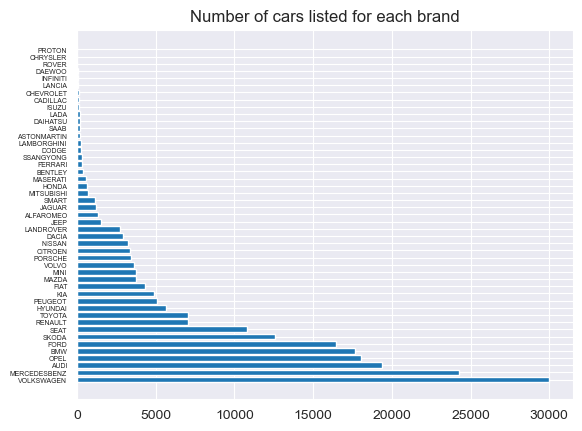

In [64]:
offer = df['brand'].value_counts()
plt.barh(offer.index, offer.values)
plt.yticks(fontsize=5)
plt.title('Number of cars listed for each brand')
plt.show()

The graph shows the number of cars listed for each brand in ascending order from top to bottom. We can see that most of the cars listed are primarily Volkswagen, then Mercedes-Benz, Audi, Opel and BMW.

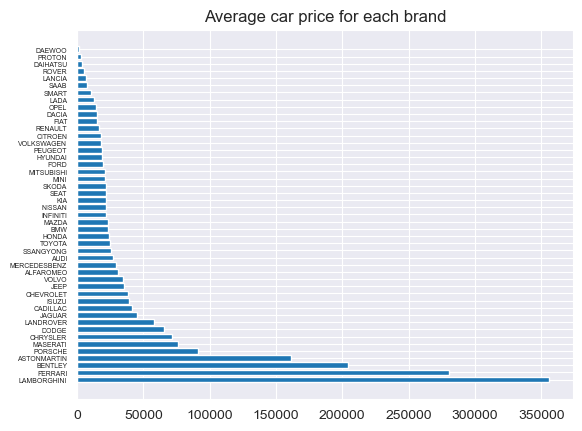

In [65]:
average = df[['brand', 'price_in_euro']].groupby('brand').mean().sort_values(by='price_in_euro', ascending=False)
plt.barh(average.index, average.price_in_euro)
plt.yticks(fontsize=5)
plt.title('Average car price for each brand')
plt.show()

The graph shows the average car price for each car brand listed. We can see that the brand with the most expensive cars on average is Lamborghini, followed by Ferrari, Bentley, Aston Martin and Porsche.

In [66]:
df.describe()

,year,price_in_euro,power_ps,fuel_consumption_l_100km,mileage_in_km,electric_range
count,220403.000000,2.204030e+05,220403.000000,220403.000000,2.204030e+05,220403.000000
mean,2016.104441,2.501525e+04,168.976516,6.080122,8.790944e+04,0.501599
std,5.441648,3.149883e+04,93.725653,2.591899,7.918609e+04,13.592062
min,1995.000000,1.200000e+02,5.000000,0.000000,0.000000e+00,0.000000
25%,2013.000000,1.160000e+04,110.000000,4.900000,2.701200e+04,0.000000
50%,2017.000000,1.919000e+04,150.000000,5.700000,7.100000e+04,0.000000
75%,2020.000000,2.899000e+04,190.000000,6.800000,1.300000e+05,0.000000
max,2023.000000,2.490000e+06,999.000000,173.000000,3.800000e+06,615.000000


Some descriptive statistics are displayed for numerical variables, such as central tendency by mean, measures of variability by standard deviation, minimum and maximum, quartiles. We can see that 50% of the cars were manufactured earlier than 2017. The average price of a car in the dataset is 25015. 25% of the cars have more than 190 horsepower.

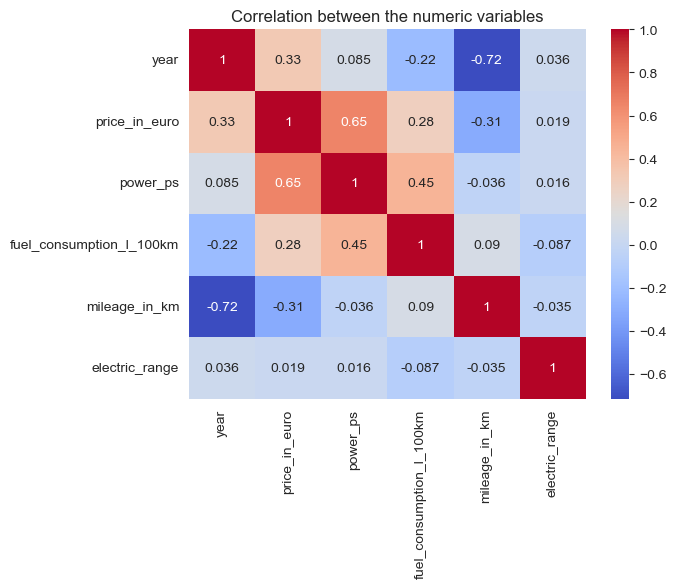

In [67]:
correlation_matrix = df[['year', 'price_in_euro', 'power_ps', 'fuel_consumption_l_100km', 'mileage_in_km', 'electric_range']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between the numeric variables')
plt.show()

There is an average positive correlation between the price of cars and their power. Between _price_in_euro_ and the variables _an_, _fuel_consumption_l_100km_, _mileage_in_km_ there is a low correlation.

## Forecasting using regression trees

In [68]:
for variable in df:
    if df[variable].dtype == 'float64':
        df[variable] = (df[variable]-df[variable].min())/(df[variable].max()-df[variable].min())

Since the variables in the dataset contain different scales, I used min-max normalization to reduce them to the range [0,1].

In [69]:
dummy = pd.get_dummies(df)
dummy.head()

,year,price_in_euro,power_ps,fuel_consumption_l_100km,mileage_in_km,electric_range,brand_ALFAROMEO,brand_ASTONMARTIN,brand_AUDI,brand_BENTLEY,...,transmission_type_Automatic,transmission_type_Manual,transmission_type_Semi-automatic,fuel_type_CNG,fuel_type_Diesel,fuel_type_Diesel Hybrid,fuel_type_Electric,fuel_type_Hybrid,fuel_type_LPG,fuel_type_Petrol
0,0.000000,0.000474,0.197183,0.063006,0.042237,0.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0.000000,0.001920,0.145875,0.054913,0.049868,0.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0.035714,0.007161,0.175050,0.041618,0.025297,0.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0.035714,0.003125,0.145875,0.054913,0.012449,0.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0.035714,0.001357,0.145875,0.050867,0.060526,0.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


All categorical variables were converted into numerical variables using dummy variables. (One hot encoding)

In [70]:
lista = []
for column_header in dummy.columns:
    lista.append(column_header)
lista.remove('price_in_euro')

In [71]:
x = dummy[lista]
y = dummy['price_in_euro']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

All variables are stored in variable _x_, except _price_in_euro_, which is stored in variable _y_, since it is our dependent variable. The data were randomly divided into training and test datasets, 20% of the data were saved in a test dataset.

### Model Evaluation

In [72]:
regression_tree = DecisionTreeRegressor()
regression_tree.fit(x_train, y_train)
print(regression_tree.score(x_test, y_test))

0.727166570902658


According to the R-squared metric (coefficient of determination), about 73% of the price change is explained by changes in the other variables.

In [73]:
prediction = regression_tree.predict(x_test)
mape = mean_absolute_percentage_error(y_test, prediction)
mape

0.2216828662023496

From the Mean Absolute Percentage Error, the predicted values are on average about 0.22% of the true values.